In [1]:
# Python Free Fermion Large Scale Simulation Platform (FermiNet) Tutorials
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

In [2]:
# My PyFerm modules:
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse, \
    mnist_single_pdf, mix_rbf_kernel, kernel_expect

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import qiskit # Qiskit is required for this demo
import math
import seaborn as sns


# Example 4: Quantum Generative Model

The quantum circuit Born Machine (QCBM) is a quantum generative model. 

QCBM utilizes a multi-layer parametrized quantum circuit (MPQC) to evolve the initial/input quantum state $|\psi_0\rangle$ to some target state via unitary gates: $\left|\psi_{\theta}\right\rangle=U_{\theta}|\psi_0\rangle$, where $\theta$ are the parameters of the MPQ. One measures the outputs state in the computational basis to produce a classical sample (bit string) $x \sim p_{\boldsymbol{\theta}}(x)=\left|\left\langle x | \psi_{\theta}\right\rangle\right|^{2}$. Excitingly, the output probability densities of a general quantum circuit cannot be efficiently simulated by classical means, the QCBM is among the several proposals to show quantum supremacy. QCBM by minimizing the maximum mean discrepancy (MMD) loss using a Gaussian Kernel:

$\begin{equation}
    \begin{aligned}
\mathcal{L}&=\underset{x \sim p_{\theta}, y \sim p_{\theta}}{\mathbb{E}}[K(x, y)]-2 \underset{x \sim p_{\theta}, y \sim p^*}{\mathbb{E}}[K(x, y)]+\underset{x \sim p^*, y \sim p^*}{\mathbb{E}}[K(x, y)],
\end{aligned}
\end{equation}.$

In this tutorial, we use a simple multi-layer parametrized quantum circuit with related FreeFermiNet classes and functions.

We define one circuit gate Hamiltonian as $H_g$, and each gate corresponds to a continuous evolution $e^{-i\mathcal{H}_{g}t}$. A parametrized is a series of such evolutions:

$U_{total} = U_L U_{L-1}...U_{2} U_1, $

where $U_l$ is the $l$-th "layer" defined as:

$U_l = e^{-i\mathcal{H}_{l}t},$

where at each layer, $\mathcal{H}_{l}$ concerns interactionos of two Fermionic modes $i<j$, not necessarily nearest-neighbor. In this example, we use a simple construction (refer to Tutorial 1 for more details):

$\begin{equation}
    \begin{aligned}
        \mathcal{H}_{l} &=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+(c+di) a_i^{\dagger} a_j+(c-di) a_j^{\dagger} a_i \\ &= -\frac{1}{2} \left(b_{ii} Z_i + b_{jj} Z_j\right)+\frac{c}{2} \left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j + X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j \right)\\
        &+\frac{d}{2}\left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j - X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j \right),
    \end{aligned}
\end{equation}$

In [3]:
pdf_data_img,_ = mnist_single_pdf(0, 9, (5,5))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



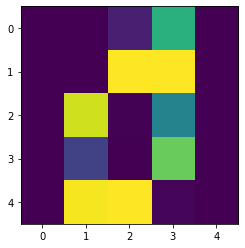

In [4]:
plt.imshow(pdf_data_img)

In [5]:
pdf_data = torch.zeros(2**5, dtype=torch.float)
pdf_data[:25] = torch.tensor(pdf_data_img.flatten(), dtype=torch.float)
print(pdf_data)

tensor([0.0000, 0.0000, 0.0123, 0.0900, 0.0000, 0.0000, 0.0000, 0.1415, 0.1415,
        0.0000, 0.0000, 0.1314, 0.0006, 0.0632, 0.0000, 0.0000, 0.0274, 0.0000,
        0.1085, 0.0000, 0.0000, 0.1398, 0.1415, 0.0022, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


/var/folders/66/87ywc69x2c5_cqkhm3p3f4l00000gn/T/ipykernel_66906/4032754336.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pdf_data[:25] = torch.tensor(pdf_data_img.flatten(), dtype=torch.float)


In [6]:
n_fermions = 5
factor = 10
N = factor * n_fermions
basis_m_n = binary_basis(geometry=(n_fermions,)) # The basis in the probability space

conn_list = [ [np.min(p), np.max(p)] for p in get_nn_pairs(geometry=(N,))]*2

print('conn_list', conn_list)
L = len(conn_list) # Number of layers

# 101010...10
x_input = torch.tensor([[1]*(N//factor)+[0]*(N-N//factor)]) if N%2==0 else torch.tensor([[1,0]*int(N/2)+[1]])

# Initialize the circuit
circuit = Network(conn_list, N)
print('circuit.parameters()', circuit.parameters())

# Initialize the circuit
circuit = Network(conn_list, N)

beta1 = 0.5
lr_G = 1e-1
optimizerG = torch.optim.Adam(circuit.parameters(), lr=lr_G, betas=(beta1, 0.999)) #The parameters are the th
def kl(p_data, probs_batch):
    return torch.sum(p_data * torch.log(p_data/(probs_batch+1e-12)))
def tv_sqr(p_data, probs_batch):
    return torch.sum(torch.square(probs_batch-p_data))


# MMD loss by tracking the full probability space [0.5, 0.1, 0.2, 0.25,4,10]
K = torch.tensor(mix_rbf_kernel(basis_m_n, basis_m_n, sigma_list=[0.002, 0.5, 0.1, 0.2, 0.25,4,10]), dtype=torch.float)
def exact_mmd(pdf_data, pdf_model): #input are tensors
    # print('debug pdf_data', pdf_data)
    # print('debug pdf_model', pdf_model)
    # parmas_L_by_4 = parmas_L_times_4.reshape((L, 4))
    # bij_vec = parmas_L_by_4[:,2]+parmas_L_by_4[:,3]*1j # the bij has a real part and a complex part
    # params_L_3 = np.concatenate((parmas_L_by_4[:,0:2], bij_vec[:,None]), axis=1)
    p_diff = pdf_data-pdf_model # Although this puts a constant term to the loss value, it is easier to code this way
    return kernel_expect(K, p_diff, p_diff)


conn_list [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [23, 24], [25, 26], [27, 28], [29, 30], [31, 32], [33, 34], [35, 36], [37, 38], [39, 40], [41, 42], [43, 44], [45, 46], [47, 48], [0, 49], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [23, 24], [25, 26], [27, 28], [29, 30], [31, 32], [33, 34], [35, 36], [37, 38], [39, 40], [41, 42], [43, 44], [45, 46], [47, 48], [0, 49]]
circuit.parameters() <generat

/Users/pengyuanzhai/Documents/NFNet/Utils_torch_version.py:45: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646981653/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  return px@K@py.T


iter, obj (0, tensor(2.1313, grad_fn=<DotBackward0>))


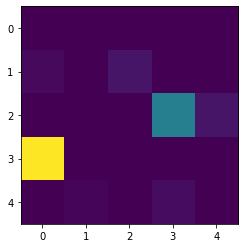

iter, obj (1, tensor(1.4056, grad_fn=<DotBackward0>))
iter, obj (2, tensor(1.0030, grad_fn=<DotBackward0>))
iter, obj (3, tensor(0.7954, grad_fn=<DotBackward0>))
iter, obj (4, tensor(0.6310, grad_fn=<DotBackward0>))
iter, obj (5, tensor(0.5398, grad_fn=<DotBackward0>))
iter, obj (6, tensor(0.4614, grad_fn=<DotBackward0>))
iter, obj (7, tensor(0.4290, grad_fn=<DotBackward0>))
iter, obj (8, tensor(0.3965, grad_fn=<DotBackward0>))
iter, obj (9, tensor(0.3794, grad_fn=<DotBackward0>))
iter, obj (10, tensor(0.3746, grad_fn=<DotBackward0>))
iter, obj (11, tensor(0.3724, grad_fn=<DotBackward0>))
iter, obj (12, tensor(0.3707, grad_fn=<DotBackward0>))
iter, obj (13, tensor(0.3675, grad_fn=<DotBackward0>))
iter, obj (14, tensor(0.3644, grad_fn=<DotBackward0>))
iter, obj (15, tensor(0.3614, grad_fn=<DotBackward0>))
iter, obj (16, tensor(0.3577, grad_fn=<DotBackward0>))
iter, obj (17, tensor(0.3528, grad_fn=<DotBackward0>))
iter, obj (18, tensor(0.3466, grad_fn=<DotBackward0>))
iter, obj (19, tens

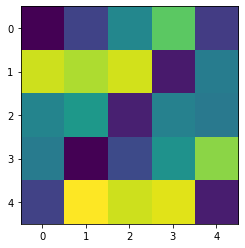

iter, obj (21, tensor(0.3272, grad_fn=<DotBackward0>))
iter, obj (22, tensor(0.3237, grad_fn=<DotBackward0>))
iter, obj (23, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (24, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (25, tensor(0.3285, grad_fn=<DotBackward0>))
iter, obj (26, tensor(0.3333, grad_fn=<DotBackward0>))
iter, obj (27, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (28, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (29, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (30, tensor(0.3199, grad_fn=<DotBackward0>))
iter, obj (31, tensor(0.3199, grad_fn=<DotBackward0>))
iter, obj (32, tensor(0.3197, grad_fn=<DotBackward0>))
iter, obj (33, tensor(0.3194, grad_fn=<DotBackward0>))
iter, obj (34, tensor(0.3193, grad_fn=<DotBackward0>))
iter, obj (35, tensor(0.3192, grad_fn=<DotBackward0>))
iter, obj (36, tensor(0.3190, grad_fn=<DotBackward0>))
iter, obj (37, tensor(0.3189, grad_fn=<DotBackward0>))
iter, obj (38, tensor(0.3188, grad_fn=<DotBackward0>))
iter, obj 

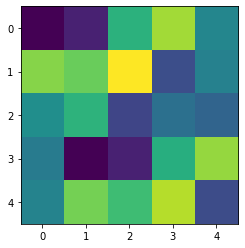

iter, obj (41, tensor(0.3186, grad_fn=<DotBackward0>))
iter, obj (42, tensor(0.3186, grad_fn=<DotBackward0>))
iter, obj (43, tensor(0.3185, grad_fn=<DotBackward0>))
iter, obj (44, tensor(0.3184, grad_fn=<DotBackward0>))
iter, obj (45, tensor(0.3184, grad_fn=<DotBackward0>))
iter, obj (46, tensor(0.3183, grad_fn=<DotBackward0>))
iter, obj (47, tensor(0.3183, grad_fn=<DotBackward0>))
iter, obj (48, tensor(0.3183, grad_fn=<DotBackward0>))
iter, obj (49, tensor(0.3182, grad_fn=<DotBackward0>))
iter, obj (50, tensor(0.3182, grad_fn=<DotBackward0>))
iter, obj (51, tensor(0.3182, grad_fn=<DotBackward0>))
iter, obj (52, tensor(0.3181, grad_fn=<DotBackward0>))
iter, obj (53, tensor(0.3181, grad_fn=<DotBackward0>))
iter, obj (54, tensor(0.3181, grad_fn=<DotBackward0>))
iter, obj (55, tensor(0.3180, grad_fn=<DotBackward0>))
iter, obj (56, tensor(0.3180, grad_fn=<DotBackward0>))
iter, obj (57, tensor(0.3180, grad_fn=<DotBackward0>))
iter, obj (58, tensor(0.3180, grad_fn=<DotBackward0>))
iter, obj 

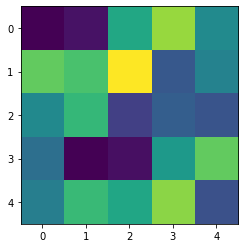

iter, obj (61, tensor(0.3179, grad_fn=<DotBackward0>))
iter, obj (62, tensor(0.3179, grad_fn=<DotBackward0>))
iter, obj (63, tensor(0.3179, grad_fn=<DotBackward0>))
iter, obj (64, tensor(0.3179, grad_fn=<DotBackward0>))
iter, obj (65, tensor(0.3179, grad_fn=<DotBackward0>))
iter, obj (66, tensor(0.3179, grad_fn=<DotBackward0>))
iter, obj (67, tensor(0.3181, grad_fn=<DotBackward0>))
iter, obj (68, tensor(0.3186, grad_fn=<DotBackward0>))
iter, obj (69, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (70, tensor(0.3240, grad_fn=<DotBackward0>))
iter, obj (71, tensor(0.3286, grad_fn=<DotBackward0>))
iter, obj (72, tensor(0.3263, grad_fn=<DotBackward0>))
iter, obj (73, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (74, tensor(0.3180, grad_fn=<DotBackward0>))
iter, obj (75, tensor(0.3182, grad_fn=<DotBackward0>))
iter, obj (76, tensor(0.3185, grad_fn=<DotBackward0>))
iter, obj (77, tensor(0.3183, grad_fn=<DotBackward0>))
iter, obj (78, tensor(0.3180, grad_fn=<DotBackward0>))
iter, obj 

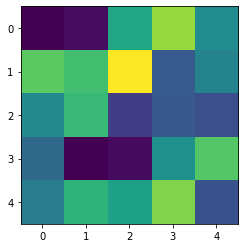

iter, obj (81, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (82, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (83, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (84, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (85, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (86, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (87, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (88, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (89, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (90, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (91, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (92, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (93, tensor(0.3178, grad_fn=<DotBackward0>))
iter, obj (94, tensor(0.3177, grad_fn=<DotBackward0>))
iter, obj (95, tensor(0.3177, grad_fn=<DotBackward0>))
iter, obj (96, tensor(0.3177, grad_fn=<DotBackward0>))
iter, obj (97, tensor(0.3177, grad_fn=<DotBackward0>))
iter, obj (98, tensor(0.3177, grad_fn=<DotBackward0>))
iter, obj 

In [7]:
n_space = basis_m_n.shape[0] # The number of total probability patterns
batchsize = 1024
num_batches = n_space//batchsize if n_space%batchsize==0 else n_space//batchsize+1

for itr in range(100): # At each iteration, measure the kl divergence and update
    #probs_theta_valid_samples = torch.zeros(bas_samples.shape[0]) # to collect the model probabilities at valid patterns
    pdf_model = torch.zeros(basis_m_n.shape[0]) # To keep full pdf for exact calculation of the MMD loss


    circuit.zero_grad() # clear the parameter gradients
    obj = torch.tensor(0.0)
    # Loop through all possible patterns in the total probability space
    for i in range(num_batches):
        y_batch = basis_m_n[i*batchsize:(i+1)*batchsize]
        x_batch = x_input.repeat_interleave(y_batch.shape[0], axis=0)
        sub_mask_batch = (torch.tensor([ [1]*(N//factor)+[0]*(N-N//factor) ])).repeat(y_batch.shape[0], 1) # Measure the first half of the qubits

        probs_batch = circuit.forward_partial_observation(y_batch, x_batch, sub_mask_batch)
        # probs_batch = torch.conj(amps_batch)*amps_batch # this is still torch.cfloat
        # Only keep the real part, as all information goes to the real part
        probs_batch = probs_batch.real
        #print('probs_batch', probs_batch)
        pdf_model[i*batchsize:(i+1)*batchsize] = probs_batch # Keep track of the gradient, as this directly goes into the loss calculation

    # in the case of calculating the exact MMD loss, which cannot be written as a sum
    obj = exact_mmd(pdf_data, pdf_model)

    obj.backward()
    optimizerG.step()
    print('iter, obj', (itr, obj))

    if itr % 20 == 0:
        #print('predicted', probs_theta_valid_samples)
        plt.plot(pdf_data.detach().numpy(), '^-')
        plt.plot(pdf_model.detach().numpy(), 'x-')
        plt.savefig('kl_training_figs/iter_'+str(itr)+'.png')
        plt.close()

        # plot the gradients
        grads_l_list = []
        for l in range(L):
            # each layer has four parameters
            grads_l = np.array([[circuit.V_l_module_list[l].bii.grad.detach().numpy()[0], circuit.V_l_module_list[l].bjj.grad.detach().numpy()[0],\
             circuit.V_l_module_list[l].bij_real.grad.detach().numpy()[0], \
            circuit.V_l_module_list[l].bij_img.grad.detach().numpy()[0]]])

            grads_l_list.append(grads_l)

        grads_4_by_l = np.concatenate(grads_l_list, axis=0).T

        ax = sns.heatmap( grads_4_by_l , linewidth = 0.5 , cmap = 'coolwarm' )
        plt.xlabel('layer No.')
        plt.ylabel('thetas 0, 1, 2, 3')
        plt.savefig('kl_training_gradients/iter_'+str(itr)+'.png')
        plt.close()

        plt.figure()
        plt.imshow(pdf_model[:25].detach().numpy().reshape(5,5))
        plt.savefig('kl_training_gradients/img_iter_'+str(itr)+'.png')
        plt.imsave('kl_training_gradients/img_iter_'+str(itr)+'.png',pdf_model[:25].detach().numpy().reshape(5,5))
        plt.show()